In [ ]:
using Plots; pyplot();

using ArraysOfArrays, StaticArrays, Tables, TypedTables
using Statistics, Random, Distributions, StatsBase
using Unitful

using SolidStateDetectors

In [2]:
# example 1: BEGe
detector_config_filename = SSD_examples[:BEGe]

# example 2: InvCoax
#detector_config_filename = SSD_examples[:InvertedCoax]
# example 3: file given by David Hervas
# detector_config_filename = "/home/sagitta/_gerda-legend/legend/LEGEND_julia_tutorial/legend-julia-tutorial/public_legend_BEGe_config.json"

T = Float32 # Optional; Default is Float32, but works with Float64 as well

Float32

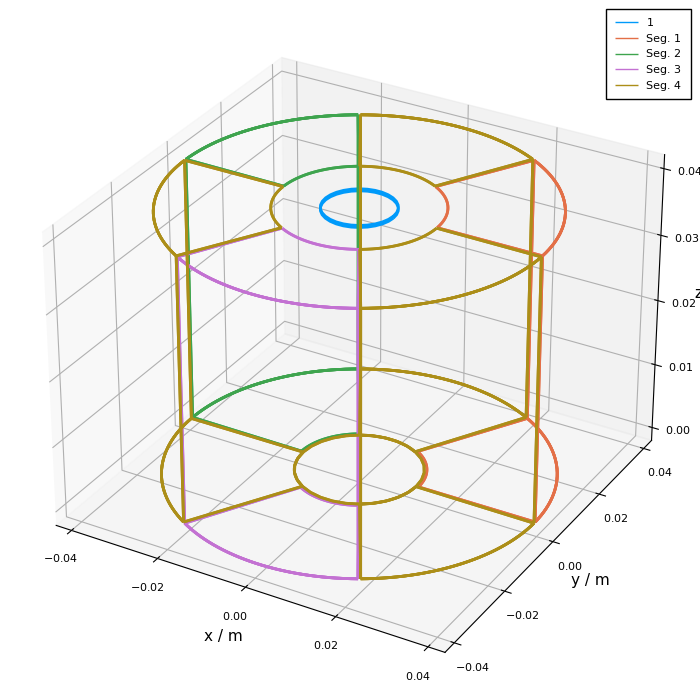

In [3]:
# ~~~~~~~~
# First, load a detector definition - here, an inverted-coaxial example detector design:
# ~~~~~~~~

simulation = Simulation{T}(detector_config_filename)
plot(simulation.detector, size = (700, 700))

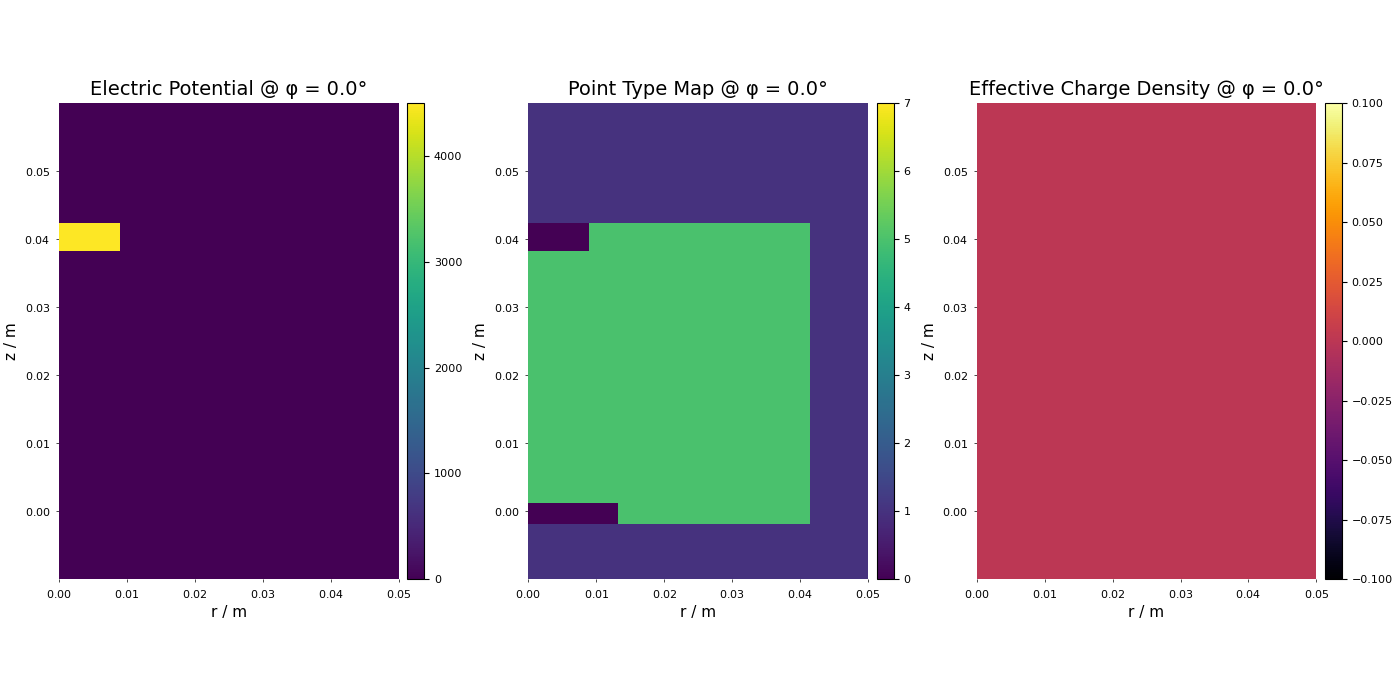

In [4]:

# ~~~~~~~~
# One can also have a look at how the initial conditions look like on the grid (its starts with a very coarse grid):
# ~~~~~~~~

# Note: this section is not needed for PS
# This is optional. Its only to have a look at the initial state.
# For example, if you want to check if you specified the detector
# geometry correctly in you .json config file.

apply_initial_state!(simulation, ElectricPotential) # optional
plot(plot(simulation.electric_potential), # initial electric potential (boundary conditions)
     plot(simulation.point_types), # map of different point types: fixed point / inside or outside detector volume / depleted/undepleted
     plot(simulation.ρ), # charge density distribution
     #plot(simulation.ϵ), # dielectric distribution
     layout = (1, 3), size = (1400, 700) )

Electric Potential Calculation
Bias voltage: 4500.0 V
φ symmetry: calculating just 1/3 in φ of the detector.
Precision: Float32
Convergence limit: 1.0e-7 => 0.00045 V
Threads: 1
Coordinate system: cylindrical
Initial grid dimension: (18, 14, 24)
Refine? -> true
Refinement parameters:
	maximum number of refinements: 4
	minimum grid spacing:
		r: 1.0e-5 m
		φ: 0.0008 rad
		z: 1.0e-5 m
	Refinement limits:
		r: 1.0e-5 -> 0.045 V
		φ: 0.0008 -> 3.6 V
		z: 1.0e-5 -> 0.045 V



Convergence:  Time: 0:00:01 (12 iterations)2422)
┌ Info: New Grid Size = (35, 16, 46)
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\Simulation\Simulation.jl:460
Convergence:  Time: 0:00:02 (24 iterations)07)m
┌ Info: New Grid Size = (69, 18, 90)
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\Simulation\Simulation.jl:460
Convergence:  Time: 0:00:07 (64 iterations)15)
┌ Info: New Grid Size = (137, 18, 178)
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\Simulation\Simulation.jl:460
Convergence:  Time: 0:00:14 (54 iterations)55)
┌ Info: New Grid Size = (273, 20, 350)
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\Simulation\Simulation.jl:460
Convergence:  Time: 0:00:58 (54 iterations)4)m


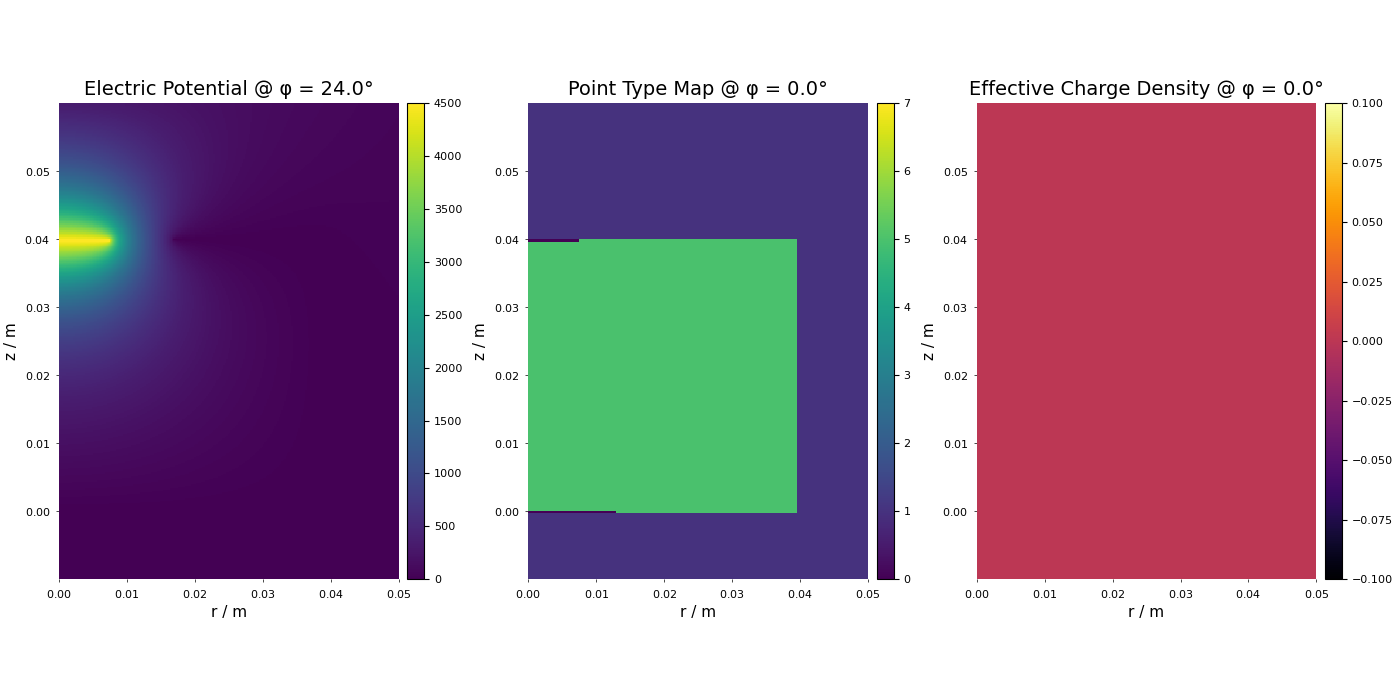

In [5]:
# ~~~~~~~~
#' Next, calculate the electric potential:
# ~~~~~~~~

calculate_electric_potential!( simulation,
                               max_refinements = 4)

# [?] why ϕ = 20 here and not before?
plot(
    plot(simulation.electric_potential, φ = 20), # initial electric potential (boundary conditions)
    plot(simulation.point_types), # map of different point types: fixed point / inside or outside detector volume / depleted/undepleted
    plot(simulation.ρ), # charge density distribution
    #plot(simulation.ϵ), # dielectric distribution
    layout = (1, 3), size = (1400, 700)
)

In [ ]:
# ~~~~~~~~
# SolidStateDetectors.jl supports active (i.e. depleted) volume calculation:
# ~~~~~~~~

# Partially depleted detectors
# Note: this section is not related to PS

detector_undep = deepcopy(simulation.detector)
detector_undep.contacts[end].potential = 500; # V  <-- Bias Voltage of Mantle
# the original potential is 2000 V?

simulation_undep = Simulation(detector_undep);
calculate_electric_potential!( simulation_undep,
                               depletion_handling = true,
                               convergence_limit=1e-6,
                               max_refinements = 4,
                               verbose = false);

println("Depleted:   ", get_active_volume(simulation.point_types))
println("Undepleted: ", get_active_volume(simulation_undep.point_types));

plot(
    plot(simulation_undep.electric_potential),
    plot(simulation_undep.point_types),
    layout = (1, 2), size = (800, 700)
)

Convergence:  Time: 0:00:00 (2 iterations)96)
┌ Warning: Detector seems not to be not fully depleted at a bias voltage of 4500.0 V.
│ At least one grid point has a higher potential value (4500.0005 V)
│ than the maximum applied potential (4500.0 V). This should not be.
│ However, small overshoots could be due to numerical precision.
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\Simulation\Simulation.jl:256
Convergence:  Time: 0:00:04 (11 iterations)75)
Checking undepleted regions 100%|███████████████████████| Time: 0:00:00
Convergence:  Time: 0:00:19 (19 iterations)
Convergence:  Time: 0:00:03 (8 iterations)309)
┌ Warning: Detector seems not to be not fully depleted at a bias voltage of 4500.0 V.
│ At least one grid point has a higher potential value (4500.0015 V)
│ than the maximum applied potential (4500.0 V). This should not be.
│ However, small overshoots could be due to numerical precision.
└ @ SolidStateDetectors C:\Users\Mohamed Emam

In [ ]:
# ~~~~~~~~
### Electric field calculation
# ~~~~~~~~

# Calculate the electric field of the fully depleted detector,
# given the already calculated electric potential:

calculate_electric_field!(simulation, n_points_in_φ = 72)  #this phi initial value is generic (not important)

# After the electric field is calculated one can determine the detector capacitance:

calculate_capacitance(simulation)

# Note: This value seems to be a bit high for an inverted coax detector.
# However, this is because the impurity density defined for this example detector
# is higher than for a real detector.
# If the bias voltage is increased (or the impurity density is set to 0),
# the capacity converges to its lower limit which is basically only defined
# through the geometry and material.

In [9]:
### Drift field calculation

# Given the electric field and a charge drift model, calculate drift fields
# for electrons and holes. Precalculating the drift fields saves time during
# charge drift simulation:

#' And apply the charge drift model to the electric field:

# this command is deprecated (old Julia versions)
#apply_charge_drift_model!(simulation)
# new format of the same command
calculate_drift_fields!(simulation)

Convergence:  Time: 0:00:03 (12 iterations)07)
Convergence:  Time: 0:00:03 (25 iterations)06)
Convergence:  Time: 0:00:12 (77 iterations)06)
Convergence:  Time: 0:00:29 (72 iterations)6)m
Convergence:  Time: 0:01:51 (52 iterations)06)
Convergence:  Time: 0:00:03 (12 iterations)07)
Convergence:  Time: 0:00:04 (28 iterations)07)
Convergence:  Time: 0:00:13 (57 iterations)06)
Convergence:  Time: 0:02:13 (66 iterations)06)
Convergence:  Time: 0:22:42 (52 iterations)06)
Convergence:  Time: 0:00:03 (12 iterations)07)
Convergence:  Time: 0:00:04 (26 iterations)07)
Convergence:  Time: 0:00:14 (60 iterations)06)
Convergence:  Time: 0:02:02 (67 iterations)06)
Convergence:  Time: 0:10:20 (53 iterations)06)
Convergence:  Time: 0:00:03 (12 iterations)07)
Convergence:  Time: 0:00:04 (26 iterations)07)
Convergence:  Time: 0:00:08 (37 iterations)06)
Convergence:  Time: 0:01:17 (43 iterations)06)
Convergence:  Time: 0:23:29 (51 iterations)06)
Convergence:  Time: 0:00:03 (13 iterations)07)
Convergence: 

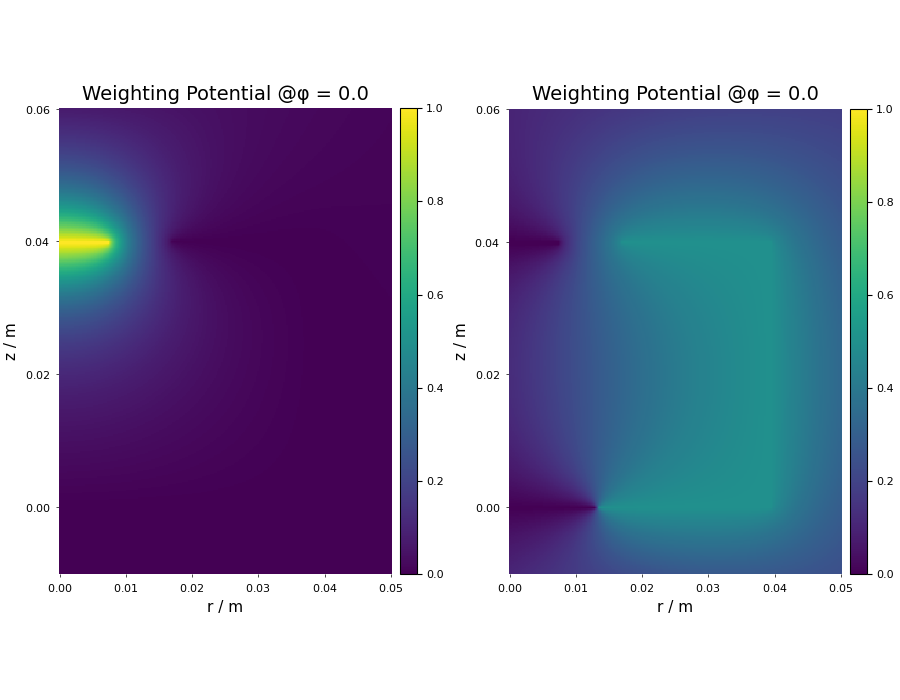

In [10]:
### Weighting potential calculation

# We need weighting potentials to simulate the detector charge signal induced by drifting charges. We'll calculate the weighting potential for the point contact and the outer shell of the detector:

for contact in simulation.detector.contacts
    calculate_weighting_potential!(simulation, contact.id, max_refinements = 4, n_points_in_φ = 2, verbose = false)
end

plot(
    plot(simulation.weighting_potentials[1]),
    plot(simulation.weighting_potentials[2]),
    size = (900, 700)
)
##


┌ Warning: Internal error for charge starting at Float32[0.014095389, 0.0051303017, 0.045]
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\deULq\src\ChargeDrift\ChargeDrift.jl:152
┌ Warning: Internal error for charge starting at Float32[0.014095389, 0.0051303017, 0.045]
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\deULq\src\ChargeDrift\ChargeDrift.jl:152
┌ Warning: Attribute alias `lw` detected in the user recipe defined for the signature (::SolidStateDetector{Float32,:cylindrical}). To ensure expected behavior it is recommended to use the default attribute `linewidth`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `lw` detected in the user recipe defined for the signature (::SolidStateDetector{Float32,:cylindrical}). To ensure expected behavior it is recommended to use the default attribute `linewidth`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots

┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}

┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}

┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Contact{Float

┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}

┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}

┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.Tube{Float32}

┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.EHDriftPath{Float32,Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `lw` detected in the user recipe defined for the signature (::SolidStateDetectors.EHDriftPath{Float32,Float32}). To ensure expected behavior it is recommended to use the default attribute `linewidth`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `c` detected in the user recipe defined for the signature (::SolidStateDetectors.EHDriftPath{Float32,Float32}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `lw` detected in the user recipe defined for the s

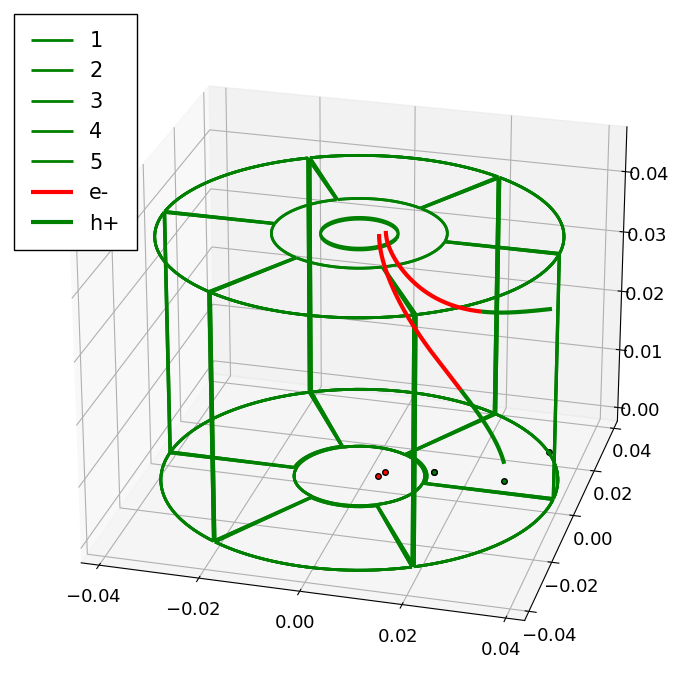

In [11]:
# ~~~~~~~~
# Drift and Waveform Simulation
# ~~~~~~~~

# Now, let's create an "random" (multiside) event:
# r, phi, z
starting_positions = [
                       # for David's LEGEND BEGe example
                       # CylindricalPoint{T}( 0.010, deg2rad(0), 0.01 ),
                       # CylindricalPoint{T}( 0.020, deg2rad(10), 0.015 ),
                       # CylindricalPoint{T}( 0.010, deg2rad(20), 0.02 )]
                       ## For Inv Coax example
                       CylindricalPoint{T}( 0.020, deg2rad(10), 0.015 ),
                       CylindricalPoint{T}( 0.015, deg2rad(20), 0.045 ),
                       CylindricalPoint{T}( 0.025, deg2rad(30), 0.025 ) ]

energy_depos = T[1460, 609, 1000] * u"keV" # are needed later in the signal generation

event = Event(starting_positions, energy_depos);

time_step = 1u"ns"
simulate!(event, simulation, Δt = time_step, max_nsteps = 2000)

plot(simulation.detector, size = (700, 700))
plot!(event.drift_paths)

┌ Warning: Attribute alias `ylabel` detected in the user recipe defined for the signature (::RadiationDetectorSignals.RDWaveform{Quantity{Float64,𝐓,Unitful.FreeUnits{(ns,),𝐓,nothing}},Float32,StepRangeLen{Quantity{Float64,𝐓,Unitful.FreeUnits{(ns,),𝐓,nothing}},Quantity{Float64,𝐓,Unitful.FreeUnits{(ns,),𝐓,nothing}},Quantity{Float64,𝐓,Unitful.FreeUnits{(ns,),𝐓,nothing}}},Array{Float32,1}}). To ensure expected behavior it is recommended to use the default attribute `yguide`.
└ @ Plots C:\Users\Mohamed Emam\.julia\packages\Plots\5ItHH\src\pipeline.jl:15
┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::RadiationDetectorSignals.RDWaveform{Quantity{Float64,𝐓,Unitful.FreeUnits{(ns,),𝐓,nothing}},Float32,StepRangeLen{Quantity{Float64,𝐓,Unitful.FreeUnits{(ns,),𝐓,nothing}},Quantity{Float64,𝐓,Unitful.FreeUnits{(ns,),𝐓,nothing}},Quantity{Float64,𝐓,Unitful.FreeUnits{(ns,),𝐓,nothing}}},Array{Float32,1}}). To ensure expected behavior it is recommended to use t

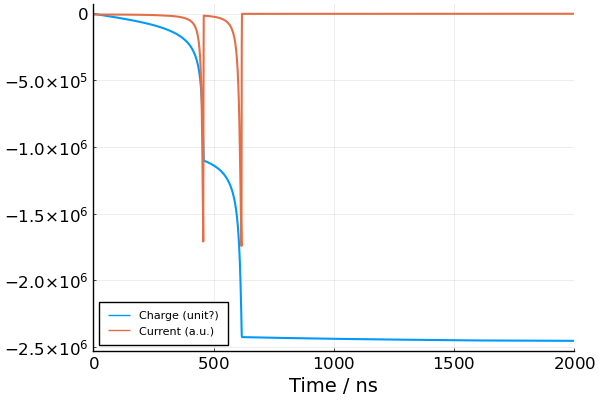

In [12]:
# ~~~~~~~~
# Waveform plot
# ~~~~~~~~


# event.waveform[1] is of type RDWaveform. Fields: time, value
plot( event.waveforms[1], lw = 1.5, xlims = (0, 2000), xlabel = "Time / ns",
                    label = "Charge (unit?)", tickfontsize = 12, guidefontsize = 14)

# This part is added by Mariia to "differentiate" the charge
# to obtain the current pulse
# This is a simplistic way of doing it, if I understood right from the
# thesis of Bjoern, the procedure is actually more complex

vd = diff(event.waveforms[1].value)*20
# for some reason doesn't want to plot with units
t = Unitful.ustrip(event.waveforms[1].time[1:end-1])

plot!(t, vd, lw = 1.5, xlims = (0, 2000), xlabel = "Time / ns", ylabel = "",
                    label = "Current (a.u.)", tickfontsize = 12, guidefontsize = 14)
